In [2]:
import sys
import os

sys.path.append(os.path.abspath('..'))

In [3]:
from utils import get_cuda_info

get_cuda_info()

PyTorch version: 2.5.1+cu118
**********
_CUDA version: 
CUDA version:
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Wed_Oct_30_01:18:48_Pacific_Daylight_Time_2024
Cuda compilation tools, release 12.6, V12.6.85
Build cuda_12.6.r12.6/compiler.35059454_0

**********
CUDNN version: 90100
Available GPU devices: 1
Device Name: NVIDIA GeForce RTX 4070 Ti SUPER


## Wybór optymalnych punktów charakterystycznych

In [5]:
import numpy as np

LANDMARK_INDEXES = np.load(os.path.join('..', '..', 'data', 'landmarks', 'combined_selected_points_smile.npy'))
REFERENCE_POINT_IDX = 0

### Wizualizacja wybranych punktów

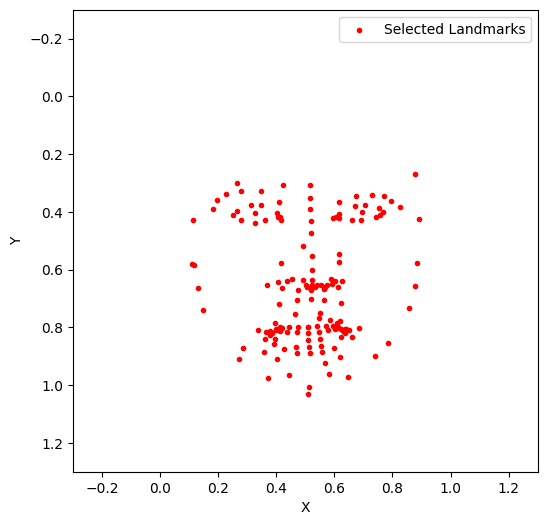

In [6]:
from utils import visualize_landmarks

visualize_landmarks(LANDMARK_INDEXES)

### Zdobycie danych

In [7]:
from utils import load_data, convert_landmarks_to_distances

all_data, all_labels = load_data('nemo_smile')
all_data = convert_landmarks_to_distances(all_data, LANDMARK_INDEXES, REFERENCE_POINT_IDX, normalize=True)

## Preprocessing danych

In [8]:
from utils import preprocess_data

X_train, X_val, X_test, y_train, y_val, y_test = preprocess_data(all_data, all_labels, binarize_labels=False)

In [9]:
print(X_train.shape)
print(y_train.shape)

torch.Size([868, 609, 158])
torch.Size([868])


In [10]:
from utils import get_class_distribution

get_class_distribution(all_labels)

===> Class distribution <===
0: 597
1: 643
=============><=============


# MODEL TORCH

## Zbudowanie modelu ekstrakcji cech

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [12]:
class SmileClassifier(nn.Module):
    def __init__(self, input_distances, nhead=4, num_transformer_layers=2, embed_dim=256):
        super(SmileClassifier, self).__init__()
        
        # Improved CNN feature extractor
        self.conv1 = nn.Conv1d(1, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(2)
        
        conv_output_size = 64 * (input_distances // 4)
        
        # Projection to transformer embed dim
        self.project = nn.Linear(conv_output_size, embed_dim)
        
        # Positional encoding - now dynamically sized
        self.pos_embed = nn.Parameter(torch.randn(1, 1000, embed_dim) * 0.02)  # Larger max length
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=nhead,
            dim_feedforward=embed_dim*4,  # Standard is 4*embed_dim
            dropout=0.1,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_transformer_layers
        )
        
        # Classification head
        self.fc1 = nn.Linear(embed_dim, 64)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 1)
        
        self._init_weights()

    def _init_weights(self):
        for name, param in self.named_parameters():
            if 'weight' in name and param.dim() > 1:
                if 'conv' in name:
                    nn.init.kaiming_normal_(param, mode='fan_out', nonlinearity='relu')
                else:
                    nn.init.xavier_normal_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0.0)
                
        # Special initialization for positional embeddings
        nn.init.normal_(self.pos_embed, std=0.02)

    def forward(self, x):
        batch_size, frames, distances = x.shape
        
        # CNN feature extraction
        x = x.view(-1, 1, distances)  # (B*T, 1, D)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        
        # Reshape for transformer
        x = x.view(batch_size, frames, -1)  # (B, T, conv_out)
        x = self.project(x)  # (B, T, embed_dim)
        
        # Add positional encoding (truncate or pad as needed)
        if frames > self.pos_embed.shape[1]:
            # If sequence longer than pos_embed, interpolate
            pos_embed = F.interpolate(
                self.pos_embed.permute(0, 2, 1),
                size=frames,
                mode='linear'
            ).permute(0, 2, 1)
        else:
            pos_embed = self.pos_embed[:, :frames, :]
        
        x = x + pos_embed
        
        # Transformer processing
        x = self.transformer_encoder(x)
        
        # Global average pooling across time dimension
        x = x.mean(dim=1)
        
        # Classification head
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

In [13]:
from torch.optim import Adam, lr_scheduler

model = SmileClassifier(input_distances=len(LANDMARK_INDEXES), nhead=8, num_transformer_layers=3)
pos_weight = torch.tensor([(len(y_train) - y_train.sum()) / y_train.sum()]).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = Adam(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

## Trening modelu

In [14]:
from torch.utils.tensorboard import SummaryWriter

writer_path = os.path.join('runs', 'torch_lstm', 'transformer')
writer = SummaryWriter(writer_path)

In [15]:
from utils.model_functions import train_torch_model_binary

train_torch_model_binary(
    model,
    criterion,
    optimizer,
    X_train,
    y_train,
    X_val,
    y_val,
    unbalanced=True,
    batch_size=32,
    epochs=200,
    lr_scheduler=scheduler,
)


                                          EPOCH STATISTICS                                          
Epoch       : 1
----------------------------------------------------------------------------------------------------
                     TRAINING                                         VALIDATION                    
----------------------------------------------------------------------------------------------------
Loss        : 18.946774                                    Loss        : 3.383967
Accuracy    : 0.5910                                    Accuracy    : 0.7043
Precision   : 0.5917                                    Precision   : 0.7063
Recall      : 0.5915                                    Recall      : 0.7052
F1 Score    : 0.5909                                    F1 Score    : 0.7041
----------------------------------------------------------------------------------------------------
                                          VALIDATION EXTRA                              

KeyboardInterrupt: 

## Ewaluacja modelu

In [16]:
from utils.model_functions import eval_torch_model_binary

eval_torch_model_binary(model, criterion, X_test, y_test)


                                          EPOCH STATISTICS                                          
Epoch       : 1
----------------------------------------------------------------------------------------------------
                                             VALIDATION                                             
----------------------------------------------------------------------------------------------------
Loss        : 3.378432
Accuracy    : 0.6935
Precision   : 0.6929
Recall      : 0.6912
F1 Score    : 0.6915
----------------------------------------------------------------------------------------------------
                                          VALIDATION EXTRA                                          
TP Rate     : 0.6477                                    FP Rate     : 0.2653

